# Example 5: Generate Synthetic Data for Two Tracers
In this example, synthetic observation data is generated for two tracers. This is done by first generating time series of tracer input for both tracers. This data is then used as a model input, together with a pre-defined set of reference parameter values (a single model / a single set of model parameter values is used for both tracers as they are applied to the same hypothetical physical system / aquifer). As a result, we obtain simulated time series of tracer concentrations of both tracers at a (hypothetical) sampling location. From this time series we select a number of values as observations (measurements of both tracers at all observed time steps); those values are perturbed by noise to include measurement error.

In [1]:
import PyTracerLab.model as ism
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## 1. Generate Synthetic Observation Data

In [2]:
# make reproducible
np.random.seed(42)

### define first input series
# define time steps
n_years = 100
timesteps = np.arange(0.0, n_years * 12.0, 1.0) # 50 years of monthly values

# this represents the tracer input to the aquifer
# we start with a constant input of 1.0
input_series_1 = np.ones(len(timesteps))
# we add a pulse of higher tracer input during some years, similar to the
# increase in tritium in the atmosphere
# this is just a bell-shaped pulse
offset = 200.
scale = - 0.0005 # negative; closer to zero means wider pulse
input_series_1 += 1000 * np.exp(scale * ((timesteps - offset) ** 2))
# add some noise to the data
input_series_1 += np.random.normal(0.0, 0.02 * input_series_1, len(input_series_1))

In [3]:
# make reproducible
np.random.seed(42)

### define second input series

# this represents the tracer input to the aquifer
# we start with a constant input of 1.0
input_series_2 = np.zeros(len(timesteps))
# we add a pulse of higher tracer input during some years, similar to the
# increase in tritium in the atmosphere
# this is just a bell-shaped pulse
offset = 200.
scale = - 0.0005 # negative; closer to zero means wider pulse
input_series_2 += 10 * np.log((timesteps / 100) + 1.1)
# add some noise to the data
input_series_2 += np.random.normal(0.0, 0.005 * input_series_2, len(input_series_2))

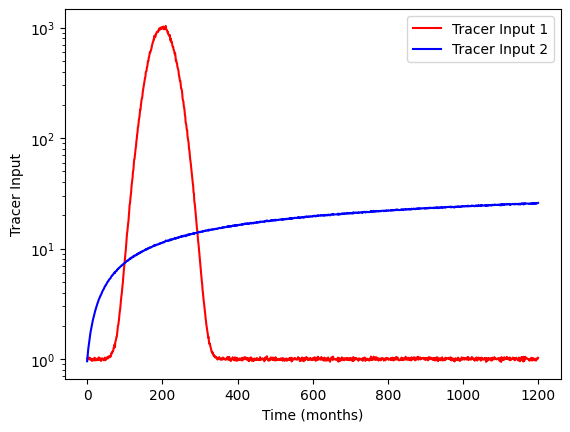

In [4]:
fig, ax = plt.subplots(1, 1)
ax.plot(
    timesteps,
    input_series_1,
    label="Tracer Input 1",
    c="red"
)
ax.plot(
    timesteps,
    input_series_2,
    label="Tracer Input 2",
    c="blue"
)
ax.set_yscale("log")
ax.set_xlabel("Time (months)")
ax.set_ylabel("Tracer Input")
ax.legend()

In [5]:
### combine signals of both tracers to array of shape (timesteps, 2)
input_series = np.column_stack((input_series_1, input_series_2))

### define model (the true system; in practice we don't know this)
# get decay constant
# we assume a half life of 12.3 years for tracer 1 (tritium)
t_half = 12.32 * 12.0
lambda_1 = np.log(2.0) / t_half

# we assume a half life of 10.73 years for tracer 2 (krypton-85)
t_half = 10.73 * 12.0
lambda_2 = np.log(2.0) / t_half

# create true observations using the model
# time step is 1 month
m = ism.Model(
    dt=1.0,
    lambda_=[lambda_1, lambda_2],
    input_series=input_series,
    steady_state_input=[1., 0.],
    n_warmup_half_lives=50
)

# add an exponential-piston-flow unit
# define the true model parameters
epm_mtt_true = 12 * 40 # 40 years
epm_eta_true = 1.5
m.add_unit(
    ism.EPMUnit(mtt=epm_mtt_true, eta=epm_eta_true),
    fraction=1., # 100 percent of the overall response
    prefix="epm"
)

true_params = m.params

# simulate
output_series = m.simulate()

In [6]:
# make reproducible
np.random.seed(11)

# define observations
# randomly select a number of observations from the output series
n_obs = 10
obs_idx = np.random.choice(len(timesteps), n_obs)
# select the corresponding timesteps and values
obs_timesteps = timesteps[obs_idx]
obs_values = output_series[obs_idx]
# add some noise to the observations (observation error)
obs_error = 0.01
obs_values += np.random.normal(0.0, obs_error, (n_obs, 2))

# make series we can later use in the model (has to be the same length as
# the input series, filled with NaN-values where we do not have any
# observations)
obs_series = np.full((len(input_series), 2), np.nan)
obs_series[obs_idx] = obs_values

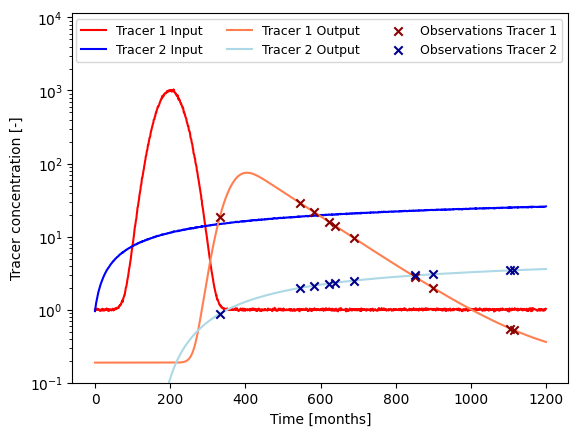

In [7]:
### plot input series, output series, and observations

# create figure
fig, ax = plt.subplots(1, 1)
# plot input series
ax.plot(
    timesteps,
    input_series_1,
    label="Tracer 1 Input",
    c="red"
)
ax.plot(
    timesteps,
    input_series_2,
    label="Tracer 2 Input",
    c="blue"
)
# plot output series
ax.plot(
    timesteps,
    output_series[:, 0],
    label="Tracer 1 Output",
    c="coral"
)
ax.plot(
    timesteps,
    output_series[:, 1],
    label="Tracer 2 Output",
    c="lightblue"
)
# plot observations
ax.scatter(
    obs_timesteps,
    obs_values[:, 0],
    label="Observations Tracer 1",
    color="darkred",
    marker="x",
    zorder=10
)
ax.scatter(
    obs_timesteps,
    obs_values[:, 1],
    label="Observations Tracer 2",
    color="darkblue",
    marker="x",
    zorder=10
)
ax.set_xlabel("Time [months]")
ax.set_ylabel("Tracer concentration [-]")
ax.set_yscale("log")
ax.set_ylim(1e-1)
ax.legend(ncol=3, fontsize=9)
plt.show()

## 2. Store Values

In [8]:
# generate dummy monthly time stamps
start = "1900-01"

start_date = datetime.strptime(start, "%Y-%m")
out = []
for i in range(n_years * 12):
    # calculate year and month offset
    year = start_date.year + (start_date.month - 1 + i) // 12
    month = (start_date.month - 1 + i) % 12 + 1
    out.append(f"{year:04d}-{month:02d}")

timestamps= np.array(out, dtype=str)

In [9]:
# concatenate timestamps and input series
input_ = np.concatenate(
    (timestamps.reshape(-1, 1),
    input_series),
    axis=1,
    dtype=object
)
# store input series as CSV
np.savetxt(
    "example_input_series_2tracer.csv",
    input_,
    delimiter=",",
    header="Date, Tracer1, Tracer2",
    fmt=["%s", "%1.3f", "%1.3f"]
)

# concatenate timestamps and observation series
obs_ = np.concatenate(
    (timestamps.reshape(-1, 1),
    obs_series),
    axis=1,
    dtype=object
)
# store observation series as CSV
np.savetxt(
    "example_observation_series_2tracer.csv",
    obs_,
    delimiter=",",
    header="Date, Tracer1, Tracer2",
    fmt=["%s", "%1.3f", "%1.3f"]
)

# concatenate timestamps and full output series
output_ = np.concatenate(
    (timestamps.reshape(-1, 1),
    output_series),
    axis=1,
    dtype=object
)
# store observation series as CSV
np.savetxt(
    "example_output_series_2tracer.csv",
    output_,
    delimiter=",",
    header="Date, Tracer1, Tracer2",
    fmt=["%s", "%1.3f", "%1.3f"]
)